# Customized Training
這次我們為實現Paper中的演算法，會對訓練過程進行調整。

傳統深度學習訓練因為有固定步驟，所以才能使用model.fit來訓練。

以下會將訓練的步驟拆解來示範如何做客製化的訓練，
內容包含:
* 定義問題和準備資料 (必經步驟)
* 建構模型 (必經步驟)
* 定義loss function 與optimization function(必經步驟)
* Training (可客製化)
     * Data Loading
     * Forward and Gradient Recording
     * Model Update

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tqdm.notebook import tqdm as tqdm_notebook
import matplotlib.pyplot as plt

### **定義問題和準備資料**
我們用簡單的sin波回歸訓練來演示
y(t)是sine波，希望透過y(t-3),y(t-2),y(t-1)預測y(t)

In [2]:
sine=np.sin(np.linspace(0,2*np.pi,10000,dtype=np.float32))
x=np.stack((sine[:-3],sine[1:-2],sine[2:-1]),-1)
y= np.expand_dims(sine[3:],-1)

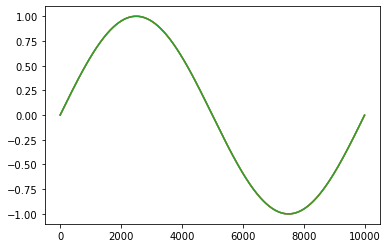

In [3]:
plt.plot(x);plt.show()

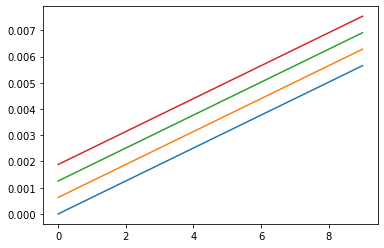

In [4]:
plt.plot(x[:10]);plt.plot(y[:10]);
plt.show()

In [5]:
print('x shape:', x.shape)
print('y shape:', y.shape)

x shape: (9997, 3)
y shape: (9997, 1)


In [6]:
x_train, x_valid, y_train, y_valid = train_test_split(x,
                                                      y,
                                                      test_size=0.1,
                                                      random_state=40)

In [7]:
print('x_train shape:', x_train.shape, '\ny_train shape:', y_train.shape)
print('x_valid shape:', x_valid.shape, '\ny_valid shape:', y_valid.shape)

x_train shape: (8997, 3) 
y_train shape: (8997, 1)
x_valid shape: (1000, 3) 
y_valid shape: (1000, 1)


### **建構模型**
因為任務簡單，這邊隨便湊一個3層的就好

In [8]:
def build_model():
    x_input = layers.Input((x_train.shape[1],))
    x = layers.Dense(4)(x_input)
    x = layers.Dense(4)(x)
    x_output = layers.Dense(1)(x)

    return keras.models.Model(x_input, x_output)

model = build_model()

### **定義 loss function**
這邊是Regression，所以選MAE loss，使用Adam optimizer

In [9]:

loss = keras.losses.MeanAbsoluteError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

### **Training**
在一般Minibatch的訓練之下，訓練的每次loop都會經歷：
1. 把資料讀出
2. 讓資料進到model算output，在中間紀錄gradient
3. 利用optimizer將model更新

In [10]:
# 建立 list 記錄訓練結果
train_loss_epoch = []
valid_loss_epoch = []

# 設定訓練參數
batch_size = 64
num_epochs = 5
num_batchs = x_train.shape[0]//batch_size

### Data Loading
依照所需的loader把data load出來，方式五花八門，這邊教學使用tf.data.Dataset做data loader
要先做好一個loader再使用loader load資料

規格: 有random shuffle；batch size 為指定size; 並且有prefetch

In [11]:
train_loader=tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(len(x_train)).batch(batch_size).prefetch(10)

每次隨機讀取一個batch,資料數就看batch size, 資料長度x是3，因為會是前三時間點資料, y是1，預測現在時間點資料

資料已經轉為tensorflow的eager tensor，與構成model使用的暫代變數KerasTensor不一樣

Eager tensor有值，丟進model後，可以從loss值反推model參數的gradient

In [12]:
for train_x,train_y in train_loader:
    break
print(f"x shape:{train_x.shape},y shape:{train_y.shape}")
print(f"x type:{type(train_x)}")
print(f"y type:{type(train_y)}")

x shape:(64, 3),y shape:(64, 1)
x type:<class 'tensorflow.python.framework.ops.EagerTensor'>
y type:<class 'tensorflow.python.framework.ops.EagerTensor'>


做多個epoch的訓練就是再加上epoch這個for loop

每個epoch可以用tqdm顯示該epoch進行的進度

In [13]:
for epoch in range(num_epochs):
    for train_x,train_y in tqdm_notebook(train_loader):
        pass
    break

### Forward and Gradient Recording
讀取資料成Eager tensor之後，就把它們放進model來算神經網路模型 forward 路徑中每層的輸出

這邊使用tf.GradientTape 紀錄每層輸出參數，後續使用tape.gradient從loss反推gradient 

In [14]:
with tf.GradientTape() as tape:
    predictions = model(train_x) # forward
    loss_value = loss(train_y, predictions) # calculate loss

# 計算 gradients = dloss / dweight (反向傳播)
gradients = tape.gradient(loss_value, model.trainable_variables)

每次with tf.GradientTape()區間只能算一次gradient，算完tape中紀錄的輸出參數會被洗掉
如果要保留tape內容，讓自己可以算多次gradient 可以使用
tf.GradientTape(persistent=True)

In [15]:
gradients

[<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
 array([[ 1.1241499 ,  0.24514814, -0.32956827,  0.14963028],
        [ 1.1242801 ,  0.24517651, -0.32960632,  0.14964761],
        [ 1.1244097 ,  0.24520478, -0.3296444 ,  0.14966486]],
       dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.14228968, -0.03102972,  0.04171522, -0.01893951], dtype=float32)>,
 <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
 array([[-0.73511845,  0.11951448, -0.69480354,  1.0593524 ],
        [-0.45746806,  0.0743745 , -0.43237996,  0.65924054],
        [ 0.6208979 , -0.1009447 ,  0.5868471 , -0.89475346],
        [-0.70756304,  0.11503458, -0.6687594 ,  1.0196432 ]],
       dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.05871781, -0.00954626,  0.05549767, -0.0846161 ], dtype=float32)>,
 <tf.Tensor: shape=(4, 1), dtype=float32, numpy=
 array([[ 0.7448536 ],
        [-0.09174594],
        [ 0.5354955 ],
        [-1.7015507 ]], dtype=float32)>,
 <tf.Tensor: 

算出來的gradient跟model可訓練參數mode.trainable_variabels是一樣大小，是個list，每個項目是一個layer中所有參數的gradient

包含gradient of weight跟gradient of bias

### Model Update
剛剛算出來的gradient可以拿來算要更新參數的量，例如說標準SGD的更新就是:

新參數=舊參數-gradient*learning rate

使用不同的optimizer可以做不同的更新，以下使用Adam示範

In [36]:
# 先記錄tape，算gradient
rec=model.trainable_variables[-2] # 使用 trainable_variables提取
rec_val=rec.value()
got_weights=model.get_weights()[-2] # 使用 get_weights()提取
with tf.GradientTape() as tape:
    predictions = model(train_x)
    loss_value = loss(train_y, predictions)
# 計算 gradients = dloss / dweight (反向傳播)
gradients = tape.gradient(loss_value, model.trainable_variables)

In [37]:
'''看一下原本的參數值'''
print(model.trainable_variables[-2])

<tf.Variable 'dense_2/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.72118706],
       [-0.11474198],
       [ 0.68147194],
       [-1.040599  ]], dtype=float32)>


In [38]:
# 更新權重，不同optimizer更新公式不同
optimizer.apply_gradients(zip(gradients, model.trainable_variables))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=4>

In [39]:
'''看一下參數值怎麼被改變'''
print(model.trainable_variables[-2])

<tf.Variable 'dense_2/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.72018796],
       [-0.11374866],
       [ 0.6804731 ],
       [-1.0395995 ]], dtype=float32)>


In [40]:
'''使用trainable_variables提取的項目其實是指標，會隨後續變化改變'''
rec

<tf.Variable 'dense_2/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.72018796],
       [-0.11374866],
       [ 0.6804731 ],
       [-1.0395995 ]], dtype=float32)>

In [41]:
'''使用trainable_variables.value()提取的項目就是數值，不會隨後續變化改變'''
rec_val

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[ 0.72118706],
       [-0.11474198],
       [ 0.68147194],
       [-1.040599  ]], dtype=float32)>

In [42]:
'''使用get_weights()提取的項目就是數值，不會隨後續變化改變'''
'''也因此'''
got_weights

array([[ 0.72118706],
       [-0.11474198],
       [ 0.68147194],
       [-1.040599  ]], dtype=float32)

---
後面示範整個過程，還會包含validation, 還有紀錄的部分

In [161]:
model = build_model()
loss = keras.losses.MeanAbsoluteError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

# 建立 list 記錄訓練結果
train_loss_epoch = []
valid_loss_epoch = []

# 設定訓練參數
batch_size = 64
num_epochs = 5
num_batchs = x_train.shape[0]//batch_size

# 定義 Training loop
for epoch in range(num_epochs):
    print('-------------------- epoch', epoch+1, ' --------------------')
    train_loss_batch = []
    # 每次拿一個 batch size 的資料作訓練
    for train_x,train_y in tqdm_notebook(train_loader):

        # 開始記錄所有變數的運算 (正向傳播)
        with tf.GradientTape() as tape:
            predictions = model(train_x)
            loss_value = loss(train_y, predictions)

        # 計算 gradients = dloss / dweight (反向傳播)
        gradients = tape.gradient(loss_value, model.trainable_variables)

        # 更新權重 (weights = weights - learning_rate * gradients)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss_batch.append(loss_value.numpy())

    # 計算 validation loss
    valid_loss = loss(y_valid, model(x_valid)).numpy()
    train_loss = np.mean(train_loss_batch)
    valid_loss_epoch.append(valid_loss)
    train_loss_epoch.append(train_loss)
    print('training loss:', train_loss, '\nvalidation loss:', valid_loss, '\n')

-------------------- epoch 1  --------------------


  0%|          | 0/141 [00:00<?, ?it/s]

training loss: 0.23797892 
validation loss: 0.0011241961 

-------------------- epoch 2  --------------------


  0%|          | 0/141 [00:00<?, ?it/s]

training loss: 0.0015175348 
validation loss: 0.001397986 

-------------------- epoch 3  --------------------


  0%|          | 0/141 [00:00<?, ?it/s]

training loss: 0.0014905414 
validation loss: 0.001408428 

-------------------- epoch 4  --------------------


  0%|          | 0/141 [00:00<?, ?it/s]

training loss: 0.0014387096 
validation loss: 0.001230864 

-------------------- epoch 5  --------------------


  0%|          | 0/141 [00:00<?, ?it/s]

training loss: 0.0018094939 
validation loss: 0.0011070338 



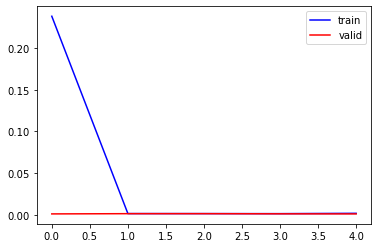

In [162]:
# 視覺化訓練過程
plt.plot(train_loss_epoch, 'b', label='train')
plt.plot(valid_loss_epoch, 'r', label='valid')
plt.legend()

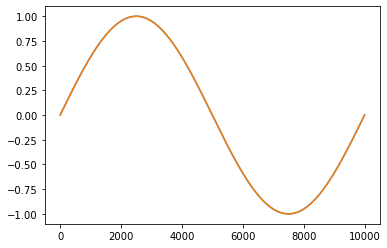

In [163]:
plt.plot(y)
plt.plot(model(x))